In [10]:
import sys
import torch
from collections import Counter
sys.path.append("../src")
from src.models import train
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt


In [11]:
# Set up device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Classes and assigned index
class_names = {'Central Serous Chorioretinopathy': 0,
               'Diabetic Retinopathy': 1,
               'Disc Edema': 2,
               'Glaucoma': 3,
               'Healthy': 4,
               'Macular Scar': 5,
               'Myopia': 6,
               'Pterygium': 7,
               'Retinal Detachment': 8,
               'Retinitis Pigmentosa': 9}

Using mps device


In [3]:
# Load data
train_loader, val_loader = train.get_dataloaders("../data/processed/normalized_dataset_subset100.pt", 
                                                 batch_size=32)

# Create model
num_classes = len(Counter(val_loader.dataset.tensors[1].tolist())) 

# Recreate the model architecture first
saved_resnet_model = train.get_resnet18(num_classes=num_classes, pretrained=False)

# Lets load the model now and use for prediction
saved_resnet_model.load_state_dict(torch.load("../models/Resnet_model_weights.pth"))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [4]:
# Example: Use the loaded model for prediction on validation data
saved_resnet_model.to(device)
saved_resnet_model.eval()  # Set to evaluation mode

# Get a batch from the validation loader
images, labels = next(iter(val_loader))
images = images.to(device)

# Forward pass
with torch.no_grad():
    outputs = saved_resnet_model(images)
    _, preds = torch.max(outputs, 1)

# preds now contains predicted class indices for the batch
print("Predicted labels:", preds.cpu().numpy())
print("True labels:", labels.cpu().numpy())

Predicted labels: [4 1 9 0 3 2 4 0 1 6 4 2 8 3 3 9 4 0 3 2 6 6 0 4 1 4 9 5 8 0 8 5]
True labels: [6 1 9 5 3 2 3 0 1 6 2 4 8 3 5 9 2 0 4 2 3 6 0 4 1 2 9 1 8 0 8 5]


Validation Loss: 0.8830, Validation Accuracy: 0.7246


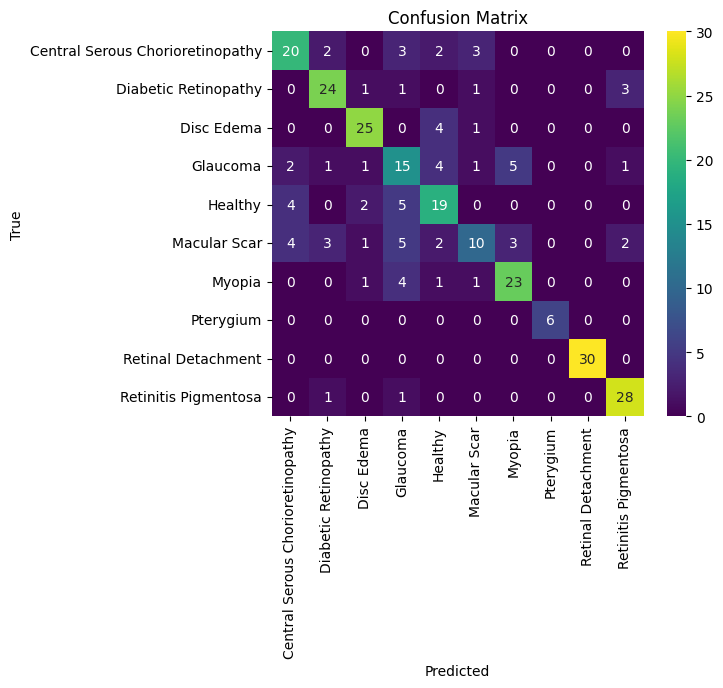

In [ ]:
sys.path.append("../src")
from visualization.plot_performance import plot_confusion_matrix

# Evaluate the loaded model on the validation set
avg_val_loss, val_acc = train.evaluate_model(saved_resnet_model, val_loader, device=device)
print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

plot_confusion_matrix(saved_resnet_model, val_loader, class_names, 
                      device=device, normalize=False)
plt.show()

### Lets predict a single image


In [9]:
# Predict a single image and match it with its class name

# Suppose you have a single image tensor: single_image
# Shape should be [1, C, H, W] (batch dimension included)
# Example: single_image = images[0].unsqueeze(0)  # Take first image from batch

single_image = images[0].unsqueeze(0).to(device)  # Get one image and add batch dim

saved_resnet_model.eval()
with torch.no_grad():
    output = saved_resnet_model(single_image)
    pred_idx = output.argmax(dim=1).item()  # Get predicted class index

# Map index to class name
class_names = [
    'Central Serous Chorioretinopathy',
    'Diabetic Retinopathy',
    'Disc Edema',
    'Glaucoma',
    'Healthy',
    'Macular Scar',
    'Myopia',
    'Pterygium',
    'Retinal Detachment',
    'Retinitis Pigmentosa'
]
pred_class = class_names[pred_idx]
print(f"Predicted class: {pred_class}")

Predicted class: Healthy


In [20]:
single_image

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [11]:
from PIL import Image
import torch
sys.path.append("../src")
from preprocess import preprocessing

# Path to your image
img_path = "../data/external/data/Subset100/Healthy/Healthy559.jpg"  # or .png

# Load and preprocess the image
img = Image.open(img_path).convert("RGB")
transform = preprocessing.get_transforms(img_size=(224, 224))  # Use the same size as your model
img_tensor = transform(img)  # Shape: [C, H, W]
img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Predict
# saved_resnet_model.eval()
with torch.no_grad():
    output = saved_resnet_model(img_tensor)
    pred_idx = output.argmax(dim=1).item()

pred_class = class_names[pred_idx]
print(f"Predicted class: {pred_class}")

Predicted class: Healthy


In [2]:
torch.__version__

'2.6.0'